In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from torch.optim import SGD, Adam

import matplotlib.pyplot as plt

from datasets import get_dataset
from loss_fns import get_loss
from utils import solve

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

/home/farshed.abdukhakimov/.conda/envs/sps2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cpu')

In [3]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

In [4]:
torch.random.manual_seed(0)

# parameters for D
alpha = 1e-4
beta=0.999
# parameters for slack
lmd = 0.01
mu = 0.1

# Setup
batch_size = 64
dataset_name = "mushrooms"
percentage = 1.0

# training 
STEPS = 100
loss_name = "logreg"
loss_class = get_loss(loss_name)

scale_k = 0
scale_range = [-scale_k, scale_k] # [-value, value]
# train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_range, loss_class.y_range)
train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_range)


# X = torch.cat((train_data, train_data, train_data))
# Y = torch.cat((train_target, train_target, -train_target))

X = train_data
Y = train_target

train_data = X.to(torch.get_default_dtype())
train_target = Y.to(torch.get_default_dtype())
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

/home/farshed.abdukhakimov/projects/sps2/datasets


In [5]:
# np.random.seed(0)
# n = 1000
# d = 2000
# A = np.random.randn(n,d)
# xopt = np.random.randn(d)
# b= A @ xopt 
# train_data = torch.Tensor(A)
# train_target = torch.Tensor(b)
# xopt = torch.Tensor(xopt)

# STEPS = 100
# train_load = torch.utils.data.TensorDataset(train_data, train_target)
# batch_size = 32
# train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

# def mse_t(x, A, b):
#     return 1/2*torch.mean(torch.norm(A@x-b)**2)

# def grad_mse_t(x, A, b):
#     return (A@x - b) @ A

# def hess_mse_t(x, A, b):
#     return A.T @ A

In [6]:
def logreg_t(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def logreg_np(w, X, y):
    r = -y*X.dot(w)
    expr = np.exp(r)
    return np.mean(np.log(1+expr))  

def grad_logreg_t(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( (r/(1 + r)) @ (X * -y[:, None]) ) / X.shape[0]

def grad_logreg_np(w, X, y):
    r = -y*X.dot(w)
    expr = np.exp(r)
    grad= X.T.dot(-expr/(1+expr)*y)   
    return grad / X.shape[0]   

def hess_logreg_t(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( X.T @ (  (r/torch.square(1 + r)).reshape(-1, 1) * X ) ) / X.shape[0]


def hess_logreg_np(w, X, y):
    r = np.exp(-y*X.dot(w))
    return ( X.T.dot( (r/np.square(1 + r)).reshape(-1, 1) * X ) ) / X.shape[0] 

# SGD

In [54]:
# parameters
w = torch.zeros(train_data.shape[1], device=device)
lr = 0.1
loss_function = logreg_t
grad_function = grad_logreg_t

# save loss and grad size to history
hist_sgd = []
loss = loss_function(w, train_data.to(device), train_target.to(device))
g = grad_function(w, train_data.to(device), train_target.to(device))
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_sgd.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

for step in range(STEPS):
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        loss = loss_function(w, batch_data, batch_target)
        g = grad_function(w, batch_data, batch_target)
        w.sub_(lr * g)

    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g = grad_function(w, train_data.to(device), train_target.to(device))
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_sgd.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

Loss: 0.6931471805599453 | GradNorm^2: 0.4359846080686327
Loss: 0.4486643927451059 | GradNorm^2: 0.040518149922516886
Loss: 0.3990154646480352 | GradNorm^2: 0.006391741813766258
Loss: 0.38122142109568896 | GradNorm^2: 0.005057841982821668
Loss: 0.36915668898873616 | GradNorm^2: 0.0018863846144357745
Loss: 0.36232291707642145 | GradNorm^2: 0.002181451513413841
Loss: 0.3562893167391129 | GradNorm^2: 0.0009405940201314553
Loss: 0.3535653472611265 | GradNorm^2: 0.00356215731264165
Loss: 0.3517619698963148 | GradNorm^2: 0.005902210876010475
Loss: 0.3465701555809252 | GradNorm^2: 0.0008483528273229814
Loss: 0.34408186484076864 | GradNorm^2: 0.0005905251991120491
Loss: 0.3420338992157603 | GradNorm^2: 0.00038920745787597046
Loss: 0.3418787502135959 | GradNorm^2: 0.0030341033083996624
Loss: 0.3386189883755707 | GradNorm^2: 0.0002884010396495138
Loss: 0.3374322326822824 | GradNorm^2: 0.0004912259317061974
Loss: 0.3363372182955741 | GradNorm^2: 0.0006749906564892628
Loss: 0.3352854882307705 | Gr

# Newton's Method

In [57]:
def run():
    # parameters
    w = torch.zeros(train_data.shape[1], device=device)
    loss_function = logreg_t
    grad_function = grad_logreg_t
    hess_function = hess_logreg_t

    # save loss and grad size to history
    hist_nwt = []
    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g = grad_function(w, train_data.to(device), train_target.to(device))
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_nwt.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

    for step in range(STEPS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            loss = loss_function(w, batch_data, batch_target)
            g = grad_function(w, batch_data, batch_target)
            hess = hess_function(w, batch_data, batch_target)
            hess_inv = torch.inverse(hess)
            w.sub_(hess_inv @ g)

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g = grad_function(w, train_data.to(device), train_target.to(device))
        print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
        hist_nwt.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])
    return hist_nwt

%lprun -f run run()

Loss: 0.6931471805599453 | GradNorm^2: 0.4359846080686327


_LinAlgError: torch.linalg.inv: The diagonal element 11 is zero, the inversion could not be completed because the input matrix is singular.

# B-PSPS2
$w^{t+1} \in \arg \textstyle{\min}_{w \in \mathbb{R}^d}\frac{1}{2} \| w - w^t \|_{D}^2\nonumber \\ 
\text{s.t.} \quad f_i(w^t)+\langle \nabla f_i(w^t), w - w^t \rangle +\frac{1}{2}\langle B(w-w^t), w - w^t \rangle \leq 0. \nonumber$

In [10]:
# Use true hessian diagonal instead of Hutch and compare them 


def run():

    w = torch.zeros(train_data.shape[1], device=device)

    loss_function = logreg_t
    grad_function = grad_logreg_t
    hess_function = hess_logreg_t

    # save loss and grad size to history
    hist = []
    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g = grad_function(w, train_data.to(device), train_target.to(device))
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

    # preconditioninig matrix
    precond = "none"
    if precond == "none":
        Dk = torch.ones_like(w)
        Dk_hat_inv = torch.ones_like(w)
    elif precond == "hutch":
        Dk = diag_estimate_old(w, g, 100)

    for epochs in range(STEPS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(w, batch_data, batch_target)
            g = grad_function(w, batch_data, batch_target)
            f_grad = g.clone()
            
            if precond == "hutch":
                vk = diag_estimate_old(w, g, 1)
                print(f"vk norm: {torch.norm(vk)}")
                # Smoothing and Truncation 
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha

                Dk_hat_inv = 1 / Dk_hat
            
            print(f"g norm : {torch.norm(g)}")

            if torch.norm(g) < 1e-20 or torch.isnan(torch.norm(g)):
                print("g norm < 1e-20")
                continue

            # sk = torch.randn(batch_data.shape[1], device=device)
            sk = g.clone()
            # sk = sk / sk.norm()
            # yk = Dk_hat_inv * sk
            # yk = torch.autograd.grad(g, w, grad_outputs=sk, retain_graph=True)[0]
            yk = hess_logreg_t(w, batch_data, batch_target) @ sk

            print(f"yk norm: {torch.norm(yk)}")

            # yk2 = torch.square(Dk_hat_inv) * sk
            # yk2 = torch.autograd.grad(torch.square(g), w, grad_outputs=sk, retain_graph=True)[0]

            gnorm = (g * Dk_hat_inv).dot(g)

            D_inv = torch.diagflat(Dk_hat_inv.clone().detach())

            D_inv_B = (((Dk_hat_inv * yk).reshape(-1, 1) @ yk.reshape(1, -1)) / (yk.dot(sk)))
            D_inv_B_D_inv = D_inv_B * Dk_hat_inv

            a_torch = torch.dot(f_grad, Dk_hat_inv*f_grad)
            a = a_torch.cpu().detach().numpy()

            b_torch = torch.dot(f_grad, D_inv_B_D_inv@f_grad)
            b = b_torch.cpu().detach().numpy() 

            c_torch = torch.trace(D_inv_B)
            c = c_torch.cpu().detach().numpy()

            # if torch.linalg.norm(f_grad) < 1e-8:
            #     continue

            print("loss: ", loss)
            print(f"D_inv_B norm: {torch.norm(D_inv_B)}")
            print(f"D_inv_B_D_inv norm: {torch.norm(D_inv_B_D_inv)}")
            print(f"Dk_hat_inv norm: {torch.norm(Dk_hat_inv)}")
            print(f"a: {a}")
            print(f"b: {b}")
            print(f"c: {c}") 


            if torch.any(torch.isnan(torch.tensor([a_torch, b_torch, c_torch]))):
                continue

            AA = 2 * a * c**2 - 2 * b * c
            BB = 4 * a * c - 2 * loss.item() * c**2 - 3 * b
            CC = 2 * a - 4 * c * loss.item()
            DD = - 2 * loss.item()

            # print(f"plms: {AA} {BB} {CC} {DD}")
            
            BB = BB / AA
            CC = CC / AA
            DD = DD / AA

            AA = 1.0
            
            print(f"plms: {AA} {BB} {CC} {DD}")

            # if np.abs(BB) > 1e10 or np.abs(CC) > 1e10 or np.abs(DD) > 1e10:
            #     print("continue")
            #     continue 

            def lagr(lmd):
                # b = lambda l: D_inv - (D_inv @ (l * B) @ D_inv) / (1 + torch.trace((l * B) @ D_inv))
                b = lambda lmd: D_inv - (lmd * (D_inv_B_D_inv) / (1 + lmd * c_torch)) 
                return lmd * loss -  (1/2)*lmd**2 * torch.dot(f_grad, b(lmd)@f_grad)

            lmds = solve(AA, BB, CC, DD)

            lmds = torch.from_numpy(lmds).to(device)
            
                
            print("lmds: ", lmds)
            
            lmd_max = torch.max(lmds)
            lmd_min = torch.maximum(torch.min(lmds), torch.tensor(0))

            # print(f"lmd_max: {lmd_max}, lmd_min: {lmd_min}")

            lmd_star = lmd_max
            if lagr(lmd_max) < lagr(lmd_min):
                lmd_star = lmd_min

            # print("lmd_star 2: ", lmd_star)

            # print("lmd_star: ", lmd_star)
            
            # precond = lmd_star * ((D_inv - ((D_inv @ (lmd_star * B) @ D_inv) / (1 + lmd_star * torch.trace(B @ D_inv))) ))
            precond = lmd_star * ( D_inv - (lmd_star * (D_inv_B_D_inv) / (1 + lmd_star * c_torch)) )

            # print("Precond norm: ", torch.linalg.norm(precond))
            print("==================")

            with torch.no_grad():
                w.sub_(precond @ f_grad)

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g = grad_function(w, train_data.to(device), train_target.to(device))
        print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
        hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

    return hist

# %lprun -f run run()
hist_bpsps2 = run()

Loss: 0.6931471805599453 | GradNorm^2: 6.057377027322198
g norm : 2.472430997836441
yk norm: 6.37158701931041
loss:  tensor(0.6931)
D_inv_B norm: 2.590701509232885
D_inv_B_D_inv norm: 2.590701509232885
Dk_hat_inv norm: 10.583005244258363
a: 6.1129150390625
b: 15.67031979560852
c: 2.5907015092328836
plms: 1.0 8.154597817601204 5.8483032751091 -1.6077061886585842
lmds:  tensor([ 0.2111, -7.3264, -1.0393])
g norm : 0.7488706041382496
yk norm: 1.1721547397024221
loss:  tensor(0.2144)
D_inv_B norm: 1.5741759706056941
D_inv_B_D_inv norm: 1.5741759706056941
Dk_hat_inv norm: 10.583005244258363
a: 0.5608071817423868
b: 0.8728037776349741
c: 1.5741759706056944
plms: 1.0 -4.754707840801403 -7.251523895540432 -13.612740504236779
lmds:  tensor([6.2604, 0.0000, 0.0000])
g norm : 0.19630069364036423
yk norm: 0.120498095891047
loss:  tensor(0.0582)
D_inv_B norm: 0.6139939881397013
D_inv_B_D_inv norm: 0.6139939881397013
Dk_hat_inv norm: 10.583005244258363
a: 0.03853396232368814
b: 0.023648099808534783


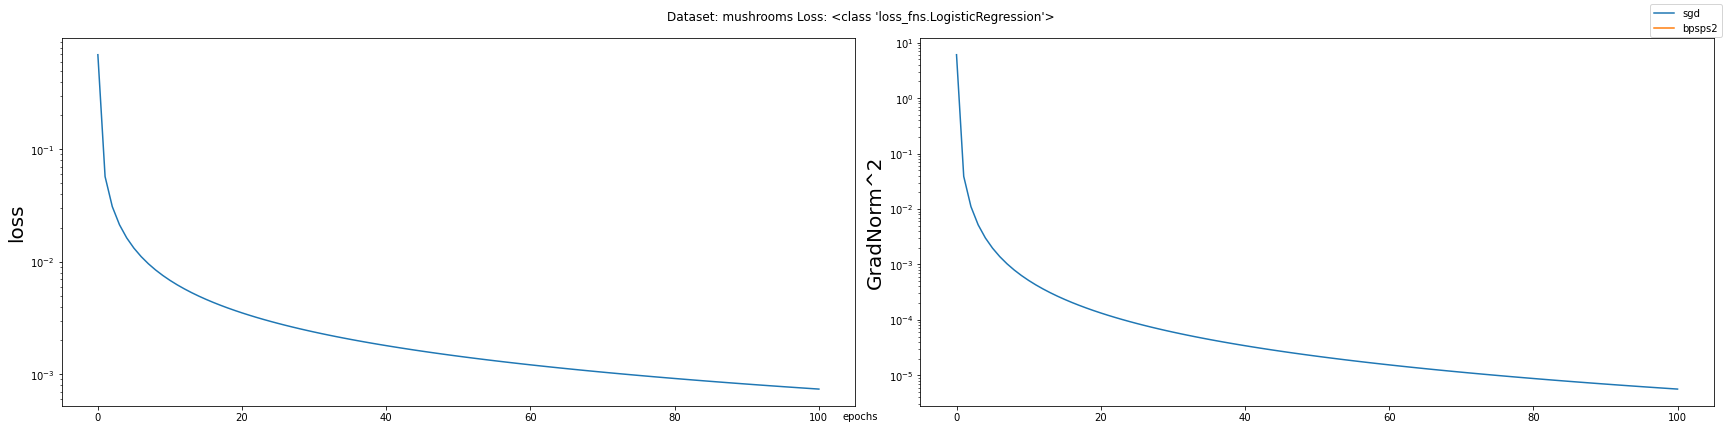

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))


ax1.semilogy([x[0] for x in hist_sgd])
ax1.semilogy([x[0] for x in hist_bpsps2])


ax2.semilogy([x[1] for x in hist_sgd])
ax2.semilogy([x[1] for x in hist_bpsps2])


ax1.set_ylabel('loss', fontsize=20)
ax2.set_ylabel('GradNorm^2', fontsize=20)

fig.text(0.5, 0.04, 'epochs', ha='center', va='center', )
fig.suptitle(f"Dataset: {dataset_name} Loss: {loss_class}")
fig.legend(['sgd', 'bpsps2'])
plt.tight_layout()
fig.show()